In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch
from mne import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

In [2]:
import glob
from pathlib import Path


files_dict = {}
for x in glob.glob('sleep-edf/sleep-cassette/*.edf'):
    temp = x.split("\\")[-1]
    subject = int(temp[3: temp.index('-')-3 ])
    night = int(temp[temp.index('-')-3])
    reading = temp[ temp.index('-')+1:temp.index('.edf') ]
    files_dict[subject,night,reading] = x

In [3]:
from itertools import islice

dict(islice(files_dict.items(),0,8))

{(0, 1, 'PSG'): 'sleep-edf/sleep-cassette\\SC4001E0-PSG.edf',
 (0, 1, 'Hypnogram'): 'sleep-edf/sleep-cassette\\SC4001EC-Hypnogram.edf',
 (0, 2, 'PSG'): 'sleep-edf/sleep-cassette\\SC4002E0-PSG.edf',
 (0, 2, 'Hypnogram'): 'sleep-edf/sleep-cassette\\SC4002EC-Hypnogram.edf',
 (1, 1, 'PSG'): 'sleep-edf/sleep-cassette\\SC4011E0-PSG.edf',
 (1, 1, 'Hypnogram'): 'sleep-edf/sleep-cassette\\SC4011EH-Hypnogram.edf',
 (1, 2, 'PSG'): 'sleep-edf/sleep-cassette\\SC4012E0-PSG.edf',
 (1, 2, 'Hypnogram'): 'sleep-edf/sleep-cassette\\SC4012EC-Hypnogram.edf'}

Using default location ~/mne_data for PHYSIONET_SLEEP...


Extracting EDF parameters from C:\Users\muppa\mne_data\physionet-sleep-data\SC4071E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


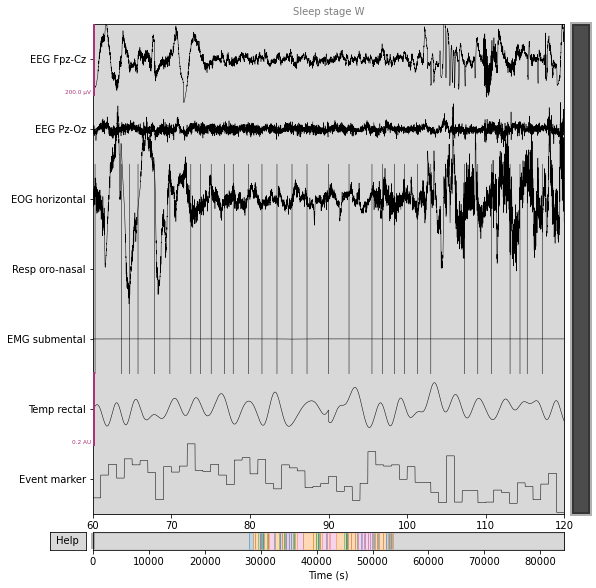

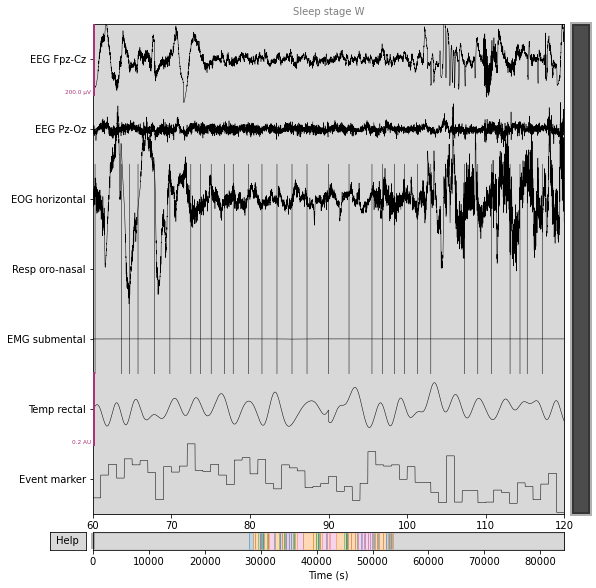

In [11]:

alice_files = [[],[]]
alice_files[0] = files_dict[7,1,'PSG']
alice_files[0] = files_dict[7,1,'Hypnogram']

bob_files = [[],[]]
bob_files[0] = files_dict[10,1,'PSG']
bob_files[0] = files_dict[10,1,'Hypnogram']

raw_train = mne.io.read_raw_edf(alice_files[0], stim_channel='Event marker',
                                misc=['Temp rectal'])
annot_train = mne.read_annotations(alice_files[1])

raw_train.set_annotations(annot_train, emit_warning=False)

raw_train.plot(start=60, duration=60,
               scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7,
                             misc=1e-1))

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


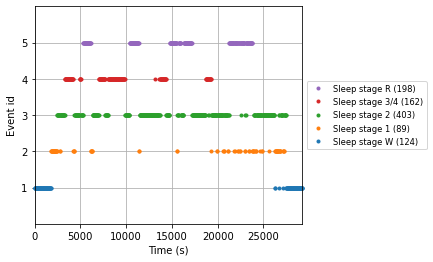

In [12]:
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

annot_train.crop(annot_train[1]['onset'] - 30 * 60,
                 annot_train[-2]['onset'] + 30 * 60)
raw_train.set_annotations(annot_train, emit_warning=False)

events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

fig = mne.viz.plot_events(events_train, event_id=event_id,
                          sfreq=raw_train.info['sfreq'],
                          first_samp=events_train[0, 0])

# color-code for further plotting
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [13]:
tmax = 30. - 1. / raw_train.info['sfreq']  # tmax in included

epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                          event_id=event_id, tmin=0., tmax=tmax, baseline=None)

print(epochs_train)

Not setting metadata
Not setting metadata
976 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  976 events (good & bad), 0 - 29.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage 1': 89
 'Sleep stage 2': 403
 'Sleep stage 3/4': 162
 'Sleep stage R': 198
 'Sleep stage W': 124>


In [14]:
raw_test = mne.io.read_raw_edf(bob_files[0], stim_channel='Event marker',
                               misc=['Temp rectal'])
annot_test = mne.read_annotations(bob_files[1])
annot_test.crop(annot_test[1]['onset'] - 30 * 60,
                annot_test[-2]['onset'] + 30 * 60)
raw_test.set_annotations(annot_test, emit_warning=False)
events_test, _ = mne.events_from_annotations(
    raw_test, event_id=annotation_desc_2_event_id, chunk_duration=30.)
epochs_test = mne.Epochs(raw=raw_test, events=events_test, event_id=event_id,
                         tmin=0., tmax=tmax, baseline=None)

print(epochs_test)

Extracting EDF parameters from C:\Users\muppa\mne_data\physionet-sleep-data\SC4101E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
Not setting metadata
1104 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  1104 events (good & bad), 0 - 29.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage 1': 65
 'Sleep stage 2': 671
 'Sleep stage 3/4': 6
 'Sleep stage R': 207
 'Sleep stage W': 155>


Loading data for 89 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 403 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 162 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 198 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 124 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 65 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 671 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 6 events and 3000 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 207

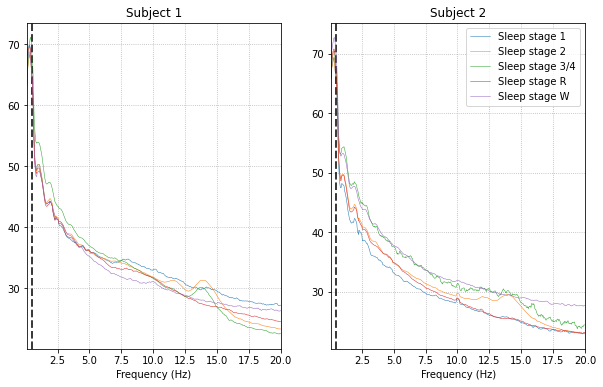

In [47]:
fig, (ax1, ax2) = plt.subplots(figsize=(10,6),ncols=2)

stages = sorted(event_id.keys())
for ax, title, epochs in zip([ax1, ax2],
                             ['Subject 1', 'Subject 2'],
                             [epochs_train, epochs_test]):

    for stage, color in zip(stages, stage_colors):
        epochs[stage].plot_psd(area_mode=None, color=color, ax=ax,
                               fmin=0.1, fmax=20., show=False,
                               average=True, spatial_colors=False)
    ax.set(title=title, xlabel='Frequency (Hz)')

ax2.legend(ax2.lines[2::3], stages)
plt.show()

In [16]:
print(epochs_train)
print(epochs_test)

<Epochs |  976 events (good & bad), 0 - 29.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage 1': 89
 'Sleep stage 2': 403
 'Sleep stage 3/4': 162
 'Sleep stage R': 198
 'Sleep stage W': 124>
<Epochs |  1104 events (good & bad), 0 - 29.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage 1': 65
 'Sleep stage 2': 671
 'Sleep stage 3/4': 6
 'Sleep stage R': 207
 'Sleep stage W': 155>


In [17]:
def eeg_power_band(epochs):
    
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30]}

    psds, freqs = psd_welch(epochs, picks='eeg', fmin=0.5, fmax=30.)
    
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

In [18]:
#RandomForest

pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
                     RandomForestClassifier(n_estimators=100, random_state=42))

# Train
y_train = epochs_train.events[:, 2]
pipe.fit(epochs_train, y_train)

# Test
y_pred = pipe.predict(epochs_test)

y_test = epochs_test.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))

Loading data for 976 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Loading data for 1104 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)
Accuracy score: 0.5978260869565217


[[ 82   7   5  43  18]
 [  6   4   2   1  52]
 [ 25  36 447  98  65]
 [  0   0   0   6   0]
 [  7  20   8  51 121]]


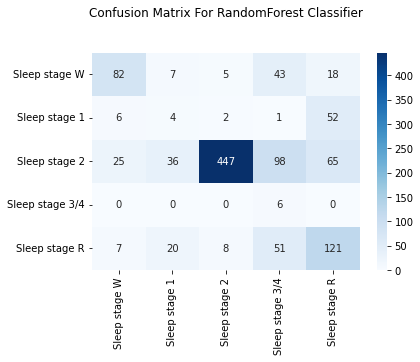

In [42]:
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

ax = sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix For RandomForest Classifier\n\n');

ax.xaxis.set_ticklabels(event_id.keys(),rotation=90)
ax.yaxis.set_ticklabels(event_id.keys(),rotation=0)
plt.show()

In [20]:
print(classification_report(y_test, y_pred, target_names=event_id.keys()))

                 precision    recall  f1-score   support

  Sleep stage W       0.68      0.53      0.60       155
  Sleep stage 1       0.06      0.06      0.06        65
  Sleep stage 2       0.97      0.67      0.79       671
Sleep stage 3/4       0.03      1.00      0.06         6
  Sleep stage R       0.47      0.58      0.52       207

       accuracy                           0.60      1104
      macro avg       0.44      0.57      0.41      1104
   weighted avg       0.78      0.60      0.67      1104



In [24]:
# AdaBoostClassifier

from sklearn.ensemble import AdaBoostClassifier

pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
                     AdaBoostClassifier(n_estimators=100))

# Train
y_train = epochs_train.events[:, 2]
pipe.fit(epochs_train, y_train)

# Test
y_pred_ada = pipe.predict(epochs_test)

y_test = epochs_test.events[:, 2]
acc_ada = accuracy_score(y_test, y_pred_ada)

print("Accuracy score: {}".format(acc_ada))

Loading data for 976 events and 3000 original time points ...
Effective window size : 2.560 (s)
Loading data for 1104 events and 3000 original time points ...
Effective window size : 2.560 (s)
Accuracy score: 0.6032608695652174


[[ 65  45  42   0   3]
 [  6  31   6   0  22]
 [  9  61 478  49  74]
 [  0   0   5   1   0]
 [  3  44  69   0  91]]


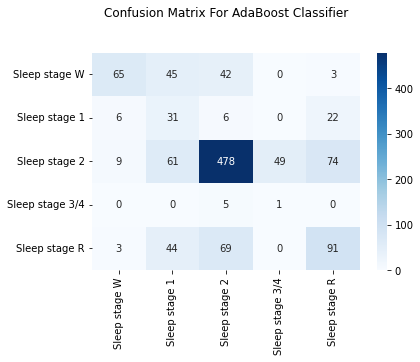

In [43]:
cf_matrix_ada = confusion_matrix(y_test, y_pred_ada)
print(cf_matrix_ada)

ax = sns.heatmap(cf_matrix_ada, annot=True, fmt='', cmap='Blues')

ax.set_title('Confusion Matrix For AdaBoost Classifier\n\n');

ax.xaxis.set_ticklabels(event_id.keys(),rotation=90)
ax.yaxis.set_ticklabels(event_id.keys(),rotation=0)
plt.show()

In [44]:
print(classification_report(y_test, y_pred_ada, target_names=event_id.keys()))

                 precision    recall  f1-score   support

  Sleep stage W       0.78      0.42      0.55       155
  Sleep stage 1       0.17      0.48      0.25        65
  Sleep stage 2       0.80      0.71      0.75       671
Sleep stage 3/4       0.02      0.17      0.04         6
  Sleep stage R       0.48      0.44      0.46       207

       accuracy                           0.60      1104
      macro avg       0.45      0.44      0.41      1104
   weighted avg       0.69      0.60      0.63      1104

